# Projeto 3

<b>Tema:</b> Estimar o retorno financeiro de um filme

<b>Técnica:</b> Regressão Linear

<b>Grupo:</b> Lucas Leal Vale, Matheus Augusto Soares, Rafael Almada
___

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

___
## _Introdução_

Neste projeto, o objetivo final do grupo, é conseguir estimar com certa precisão o retorno financeiro de um filme hipotético X dado algumas características do mesmo. Para isso estamos utilizando uma base de dados que pode ser encontrada no link abaixo:

Link do DataSet: https://www.kaggle.com/rounakbanik/the-movies-dataset#movies_metadata.csv

___

### _Filtrando a Base de Dados_

In [2]:
#Limpando DataFrame
movies=pd.read_csv('movies_metadata.csv', low_memory=False)
df=movies.loc[:, {'id','original_title','original_language','genres','popularity','runtime','budget','revenue',
                 'production_companies','production_countries', 'release_date','vote_average',}]

In [3]:
# Tirando valores de budget que estavam como arquivos de imagens e não números
df=df.drop([19730, 29503, 35587])

# Colocando algumas colunas como float para analisá-las quantitativamente
df['budget']=df['budget'].astype('float64')
df['popularity']=df['popularity'].astype('float64')
df['id']=df['id'].astype('float64')

In [4]:
#Ordenando em ordem crescente de acordo com o id, e filtrando valores 0 das variáveis float
df=df[(df['revenue']>0) & (df['budget']>0)  & (df['runtime']>0)]
df=df.sort_values(['id'], ascending=[True])
df['id']=df['id'].astype('int')
df=df.set_index('id')

___
## _Análise Exploratória dos Dados_

Aqui começamos a análise exploratória dos dados. Nosso objetivo nessa etapa é analisar como a nossa base de dados se comporta, para que assim, ao decorrer do código, é importante que estejamos cientes de como cada variável se organiza.

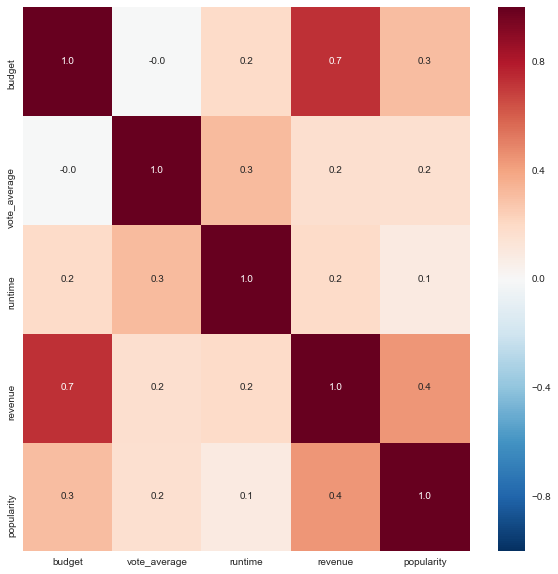

In [5]:
f,ax = plt.subplots(figsize = (10,10))
sns.heatmap(df.corr(),annot = True,fmt='.1f')

Com o gráfico acima obtemos os resultados das correlações entre cada coluna (variável). Como queremos achar uma forma de estimar o retorno financeiro de um filme ao final do projeto, precisamos analisar as variáveis em relação à variável 'Revenue'. Dessa forma percebemos que, em nossa regressão, quanto maior a correlação de uma variável X em relação à nossa variável fixada (revenue), quanto mais próxima a 1, seja positiva ou negativamente, mais importante será na nossa regressão tal variável.

Logo, das variáveis escolhidas até o momento, podemos dizer que em ordem de maior relevância no cálculo da nossa regressão estão em ordem decrescente, primeiro Budget (ou custo de produção do filme), o qual era esperado ter grande impacto no retorno do mesmo. Logo em seguida vem Popularity ou a popularidade do filme (quanto falam dele). Depois, juntos, seguem as variáveis Runtime (Tempo corrido em tela do filme) e Vote Average (Nota do filme dada pela comunidade).

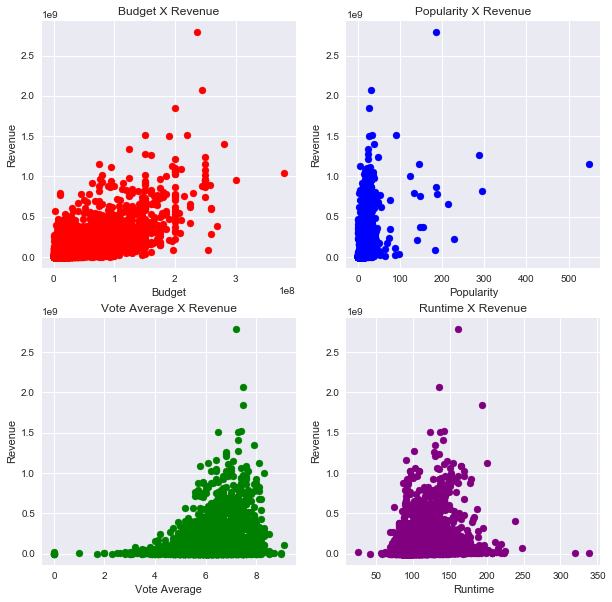

In [6]:
# Alguns ScatterPlot para analisar a dispersão dos dados em relação a revenue
fig=plt.figure(figsize=(10, 10))

# Budget X Revenue
plt.subplot(221)
plt.scatter(df.budget,df.revenue, color='red')
plt.title('Budget X Revenue')
plt.ylabel('Revenue')
plt.xlabel('Budget')

# Popularity X Revenue
plt.subplot(222)
plt.scatter(df.popularity,df.revenue, color='blue')
plt.title('Popularity X Revenue')
plt.ylabel('Revenue')
plt.xlabel('Popularity')

# Vote Average X Revenue
plt.subplot(223)
plt.scatter(df.vote_average,df.revenue, color='green')
plt.title('Vote Average X Revenue')
plt.ylabel('Revenue')
plt.xlabel('Vote Average')

#Runtime X Revenue
plt.subplot(224)
plt.scatter(df.runtime,df.revenue, color='purple')
plt.title('Runtime X Revenue')
plt.ylabel('Revenue')
plt.xlabel('Runtime')

plt.show()

Nos gráficos de dispersão acima podemos verificar o quão dispersos são os dados e visualiza-los em relação ao retorno financeiro (revenue). Percebemos que, como já visto em suas respectivas correlações, todos são positivos, logo quando o retorno é maior, a váriavel em questão (seja budget, popularidade ou tempo corrido) também é maior. A diferença desse gráfico para a tabela de correlações é que como já diz o nome deste, podemos verificar a disperção das variáveis.

A parte curiosa disso é que alguns filmes conseguem um retorno alto, mesmo tendo uma produção barata seja por motivos quaisquer, como é o caso de alguns filmes de terror que por não usar muito dinheiro, sua credibilidade aumenta, aumentando no caso também o fator "Terror" e assim chegando a cada vez mais cinemas e conseguindo um retorno de um filme blockbuster produzido por alguma empresa grande. Além disso, os gráficos nos mostram que um filme popular entre as pessoas, não necessariamente vai trazer um retorno alto.

Também temos dois gráficos que parecem um pouco com uma distribuição normal, possuindo uma média de tempo corrido de tela e classificação (ou nota) do público para o filme para um retorno maior do longa.

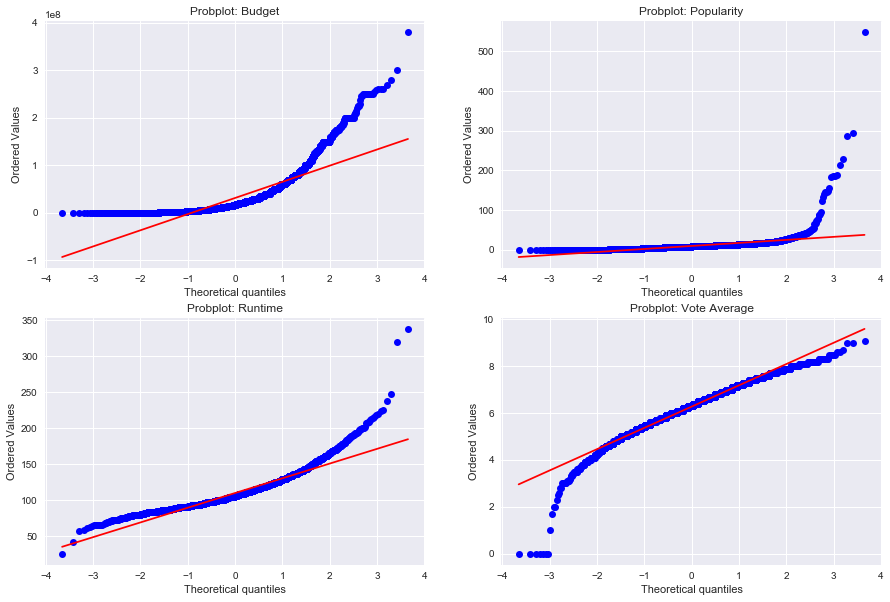

In [7]:
# Gráficos que verificam se alguma das variáveis analisadas tende a uma distribuição normal
fig=plt.figure(figsize=(15, 10))

plt.subplot(221)
stats.probplot(df.budget, plot=plt)
plt.title('Probplot: Budget')

plt.subplot(222)
stats.probplot(df.popularity, plot=plt)
plt.title('Probplot: Popularity')

plt.subplot(223)
stats.probplot(df.runtime, plot=plt)
plt.title('Probplot: Runtime')

plt.subplot(224)
stats.probplot(df.vote_average, plot=plt)
plt.title('Probplot: Vote Average')
plt.show()

Os Probability Plots acima (gráficos que medem o quanto uma base e dados se distribui conforme uma distribuição Gaussiana ou Normal), nos mostram que nenhum das variáveis se comporta como uma. A hipótese que tínhamos anteriormente nos gráficos de dispersão, de que as variáveis "Runtime" (tempo corrido de tela) e "Vote Average" (nota do filme pelo público) seguem tal distribuição não se confirmam. Pelo incrível que pareça, a variável que mais tende a tal é a de popularidade do filme com o público, independendo de sua nota dada pelo mesmo. Porém não se pode dizer que nenhuma das variáveis se distribui de forma gaussiana, anulando essas hipóteses.

Agora podemos seguir adiante da Análise exploratória dos dados.

___
## Iniciando a Regressão Linear Múltipla

In [8]:
X=df[['budget', 'popularity', 'runtime', 'vote_average']]
xc=sm.add_constant(X)
model=sm.OLS(df.revenue,xc)
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     2035.
Date:                Thu, 22 Nov 2018   Prob (F-statistic):               0.00
Time:                        13:30:34   Log-Likelihood:            -1.0677e+05
No. Observations:                5369   AIC:                         2.135e+05
Df Residuals:                    5364   BIC:                         2.136e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.761e+08   1.08e+07    -16.266      0.000   -1.97e+08   -1.55e+08
budget           2.7534      0.038     71.942      0.000       2.678       2.828
popularity    2.566e+06    1.1e+05     23.235      0.000    2.35e+06    2.78e+06
runtime       2225.7085   7.17e+04      0.031      0.975   -1.38e+05    1.43e+05
vote_average  2.478e+07   1.66e+06     14.915      0.000    2.15e+07     2.8e+07
==============================================================================
Omnibus:                     4175.948   Durbin-Watson:                   1.765
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           229343.981
Skew:                           3.245   Prob(JB):                         0.00
Kurtosis:                      34.354   Cond. No.                     3.87e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.87e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Com o primeiro teste de regressão linear múltipla feita na célula acima (utilizando a biblioteca Statsmodels), conseguimos ter uma visão inicial do caminho que devemos seguir a partir de agora. Vamos analisar!

Primeiro vamos olhar para o nosso **`R`²** que possui o valor de **0.603**. Dado esse valor, sabemos que a regressão ainda tem muito a ser melhorada (quanto mais próximo de **1** o **`R²`**, mais preciso está o modelo), devemos olhar para mais variáveis que possam explicar nosso modelo. No caso utilizamos por enquanto apenas as variáveis quantitativas, mas ainda temos algumas Qualitativas para implementar em nosso modelo.

A segunda coisa que devemos dar nossa atenção são as **`P-values`**, sendo que todas as variáveis, exceto uma, possuem um **`p-value`** de **0**, porém temos _runtime_ que possui **0.975**. O problema de um valor alto nesse caso é porque isso prova que a variável em questão está mais atrapalhando do que ajudando a precisão da nossa regressão.

As últimas coisas que devemos dar enfoque na primeira análise do modelo são a **`Prob(F-statistic)`**, a **`Prob(Omnibus)`** e a **`Prob(Jarque-Bera)`**. No caso a **`F-statistic`** coloca sob a hipótese nula de que todos os $\beta$ 's (a não ser o $\beta_0$) são iguais a zero e verifica o quão próximo tal modelo estaria do então calculado. Dado que a probabildade é **0**, logo podemos afirmar que o modelo precisa de tais variáveis.

Já a **`Prob(Omnibus)`** testa se os resíduos do nosso modelo tendem a uma normal. É importante que os resíduos tendam a uma distribuição gaussiana, pois se os resíduos não se distribuírem como uma normal, então a hipótese de que eles se comportam como uma amostra aleatória de uma população maior será dada como uma mentira e isso comprometerá totalmente a veracidade da regressão. No caso temos **$Prob(Omnibus) = 0.00$**, sendo assim não podemos confiar neste modelo. 

Ainda temos a **`Prob(JB)`** que realiza o teste chamado **`Jarque-Bera`**, que utiliza as mesmas hipóteses que o teste **`Omnibus`**, porém utilizando um método diferente, fazendo uso do grau de assimetria da distribuição (Skew) e do grau de achatamento da mesma (Kurtosis). Um **`Skew`** mais próximo de **0** e um **`Kurtosis`** mais próximo de **3** são os mais precisos para uma distribuição gaussiana dos resíduos, porém ainda temos resíduos _"reprovados"_ em ambos os testes.

In [9]:
# Removendo a coluna df.runtime
df=df.drop(columns=['runtime'])

In [10]:
# Função que retorna uma lista com os diferentes tipos de classificações. Ex: Diferentes tipos de generos de filmes
def coluna(df): # O argumento é uma coluna do dataframe com listas para cada filme
    lista=[] # lista que vamos retornar no final
    for i in df: # percorre o dataframe, filme por filme
        for j in i: # percorre a lista de cada filme
            if j not in lista:
                lista.append(j) # adiciona categorias únicas sem repetição à lista
            else:
                pass
    return lista

In [11]:
# Função que transforma o dicionário que vem em genres e cria uma lista com listas de generos para cada filme
def func_genero(filme): # Recebe uma string que contém dicionarios
    l=eval(filme)
    retl = []
    c=0
    for i in l:
        genero=i['name']
        c+=1
        retl.append(genero)
    return retl

In [12]:
df2 = df.copy()

In [13]:
# Arrumando a coluna de genêros para ser utilizada na regressão
df2['GENERO']=df2.genres.apply(func_genero)

In [14]:
for nome in coluna(df2.GENERO):
    df2[nome]=0

In [15]:
for k in df2.index:
    gens = df2.loc[k,:].GENERO   
    for g in gens:
        df2.loc[k,g]=1

Agora que a regressão já foi gerada é necessário tentar melhorá-la com as colunas qualitativas do dataframe. E para poder fazer uso delas é necessário trata-las, primeiro transformando em strings simples e depois adicionando no dataframe base 'df'.

Na célula de código acima, após diversas filtragens nos dados e se utilizando de funções já prontas das bibliotecas, conseguimos uma regressão mais precisa que antes. Agora com váriaveis Quantitativas (numéricas) e Qualitativas ou Categóricas. Lembrando que a primeira coisa a ser observada em um modelo de Regressão é o **$R^2$**, que com apenas as variáveis numéricas, possuía o valor de **`0.603`**, o que significa que budget (orçamento do filme), tempo corrido de tela, nota do filme dada pelo público e popularidade entre o público em geral explicam **60.3%** do retorno financeiro de um filme qualquer. Ao adicionar mais algumas variáveis Categóricas que achamos que poderiam ajudar nossa regressão, este valor subiu para **`0.712`** **(ATUALIZAR ESSE VALOR COM GÊNERO)**., um aumento de quase **`10.9%`** **(ATUALIZAR)** ao nosso **$R^2$**. Foi adicionado à regressão as seguintes variáveis: `Línguagem original do filme`, `Empresas que produziram o filme`, `Países envolvidos na produção` e `gêneros dos filmes`.

Por conta de como o pandas cria um dataframe transformando uma variável categórica em várias quantitativas (função `get_dummies`), acabamos com muitas variáveis que por serem tantas, cada uma explica uma porcentagem pequena do modelo, tendo um **`p-value`** consideravelmente alto para cada uma separada, mas sabemos que quando avaliadas como uma variável categórica, não afetam o modelo de fato, sendo o **`Prob(F-statistic)`** igual a **0** e portanto o modelo realmente precisa das variáveis utilizadas.

Continuamos também com uma **`Prob(Omnibus)`** e **`Prob(JB)`** de **0**, colocando em prova de que os resíduos estão se distribuindo como uma normal.

O modelo está preciso e consegue explicar **71.2%** do retorno financeiro de um filme qualquer.

___
## Conclusão

Concluindo, devemos relembrar a pergunta feita no início do projeto: Quais variáveis são necessárias para se explicar o retorno financeiro de um filme?

Ao longo do projeto, percebemos que variáveis quantitativas têm uma significância maior e, portanto, são mais significantes no modelo de regressão do rendimento financeiro de um filme qualquer. O mais impactante para o modelo seria o budget (valor total para se produzir o filme).
**[PRECISO TERMINAR AINDA]**